In [1]:
## This notebook is a test environment for writing/reading config files in yaml format...
    ## I want to store important parameters for saving time on reading in data in the future...

## First, import general packages for running python analysis:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz
from scipy.optimize import least_squares
import yaml
import glob

## Then, import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

In [ ]:
## 1) 0825 -- Flight from 20210826T185621: Comments only include "Large Grid 3"
#stop #prevent rerun
## Read in the Corr_Data class:
datadir='/hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/'
gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T182904Z_yale_drone_yale_digitalgain/'
corrtest0825=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite)

## Read in the Drone_Data class:
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY533.csv',site_class=gbosite)

Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> Arrays initialized with shape (124, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0080/0123

In [ ]:
## Since we know the data are from the same time we can combine them with the Concat_Class:
#plot(dronetest0825.t_arr_datetime)
#plot(corrtest0825.t_arr_datetime)
concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825)
## Use the Extract_Source_Pulses and Perform_Background_Subtraction functions:
concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[14500,15000])
concattest0825.Perform_Background_Subtraction()
concattest0825.Synchronization_Function(inputcorr=corrtest0825,inputdrone=dronetest0825,FMB_coordbounds=[50.0,50.0,150.0],FMB_ampbound=0.999)
concattest0825.Export_yaml()
concattest0825.Main_Beam_Fitting()

In [4]:
## Try fitting all channels main beam:
#def Fit_Main_Beam(inputconcat,chans,freqs,coordbounds=[50.0,50.0,150.0],ampbound=0.999):
A_popt,A_PR,G_popt,G_PR=fu.Fit_Main_Beam(concattest0825,chans=np.arange(16),freqs=np.arange(1024))

np.savez('2dGauss_and_Airy_Params.npz',A_popt=A_popt,A_PR=A_PR,G_popt=G_popt,G_PR=G_PR)

/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


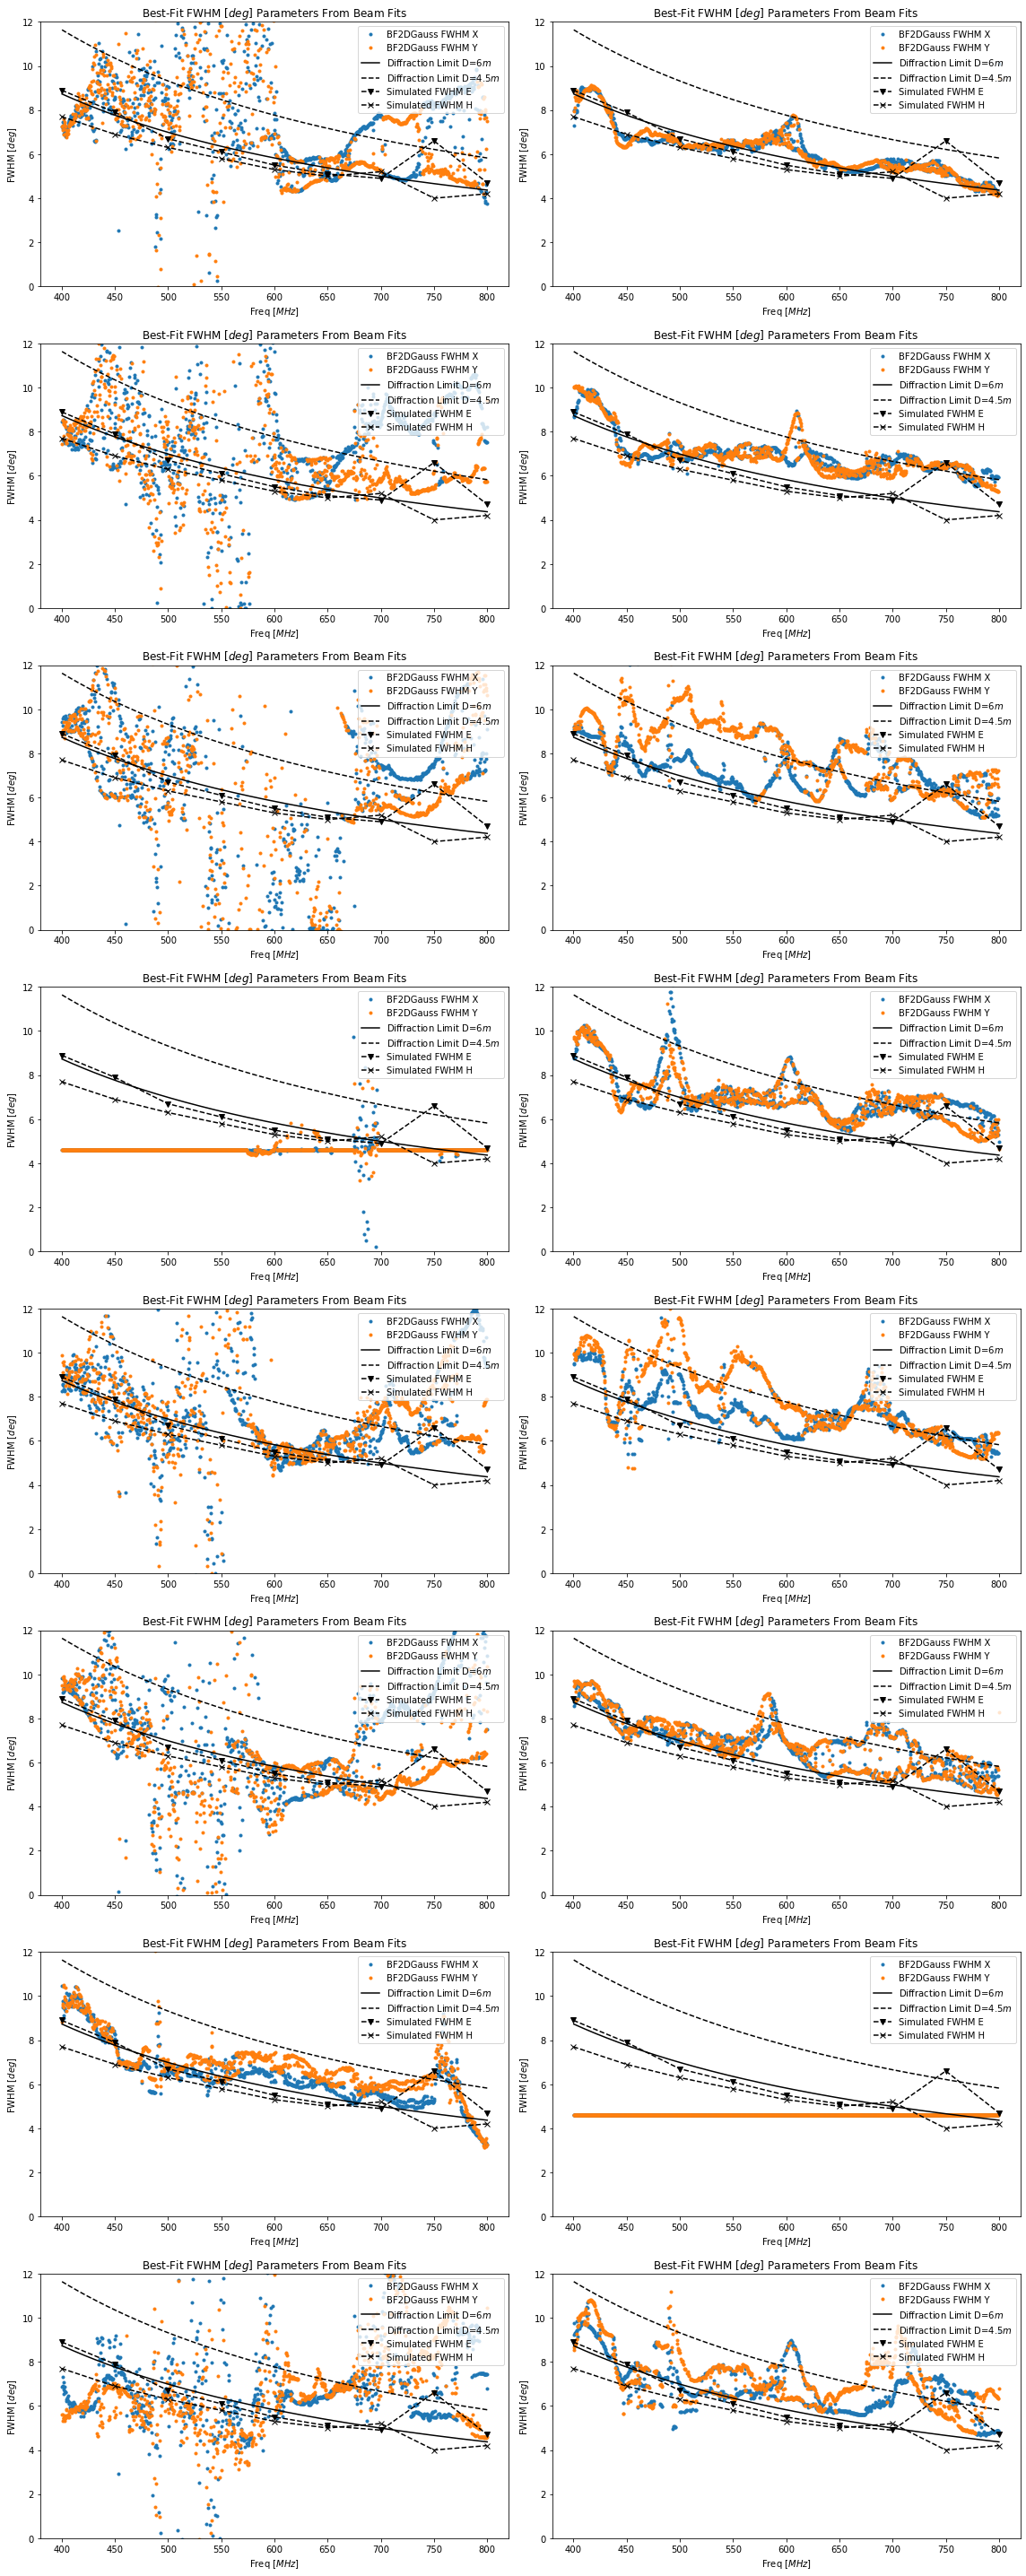

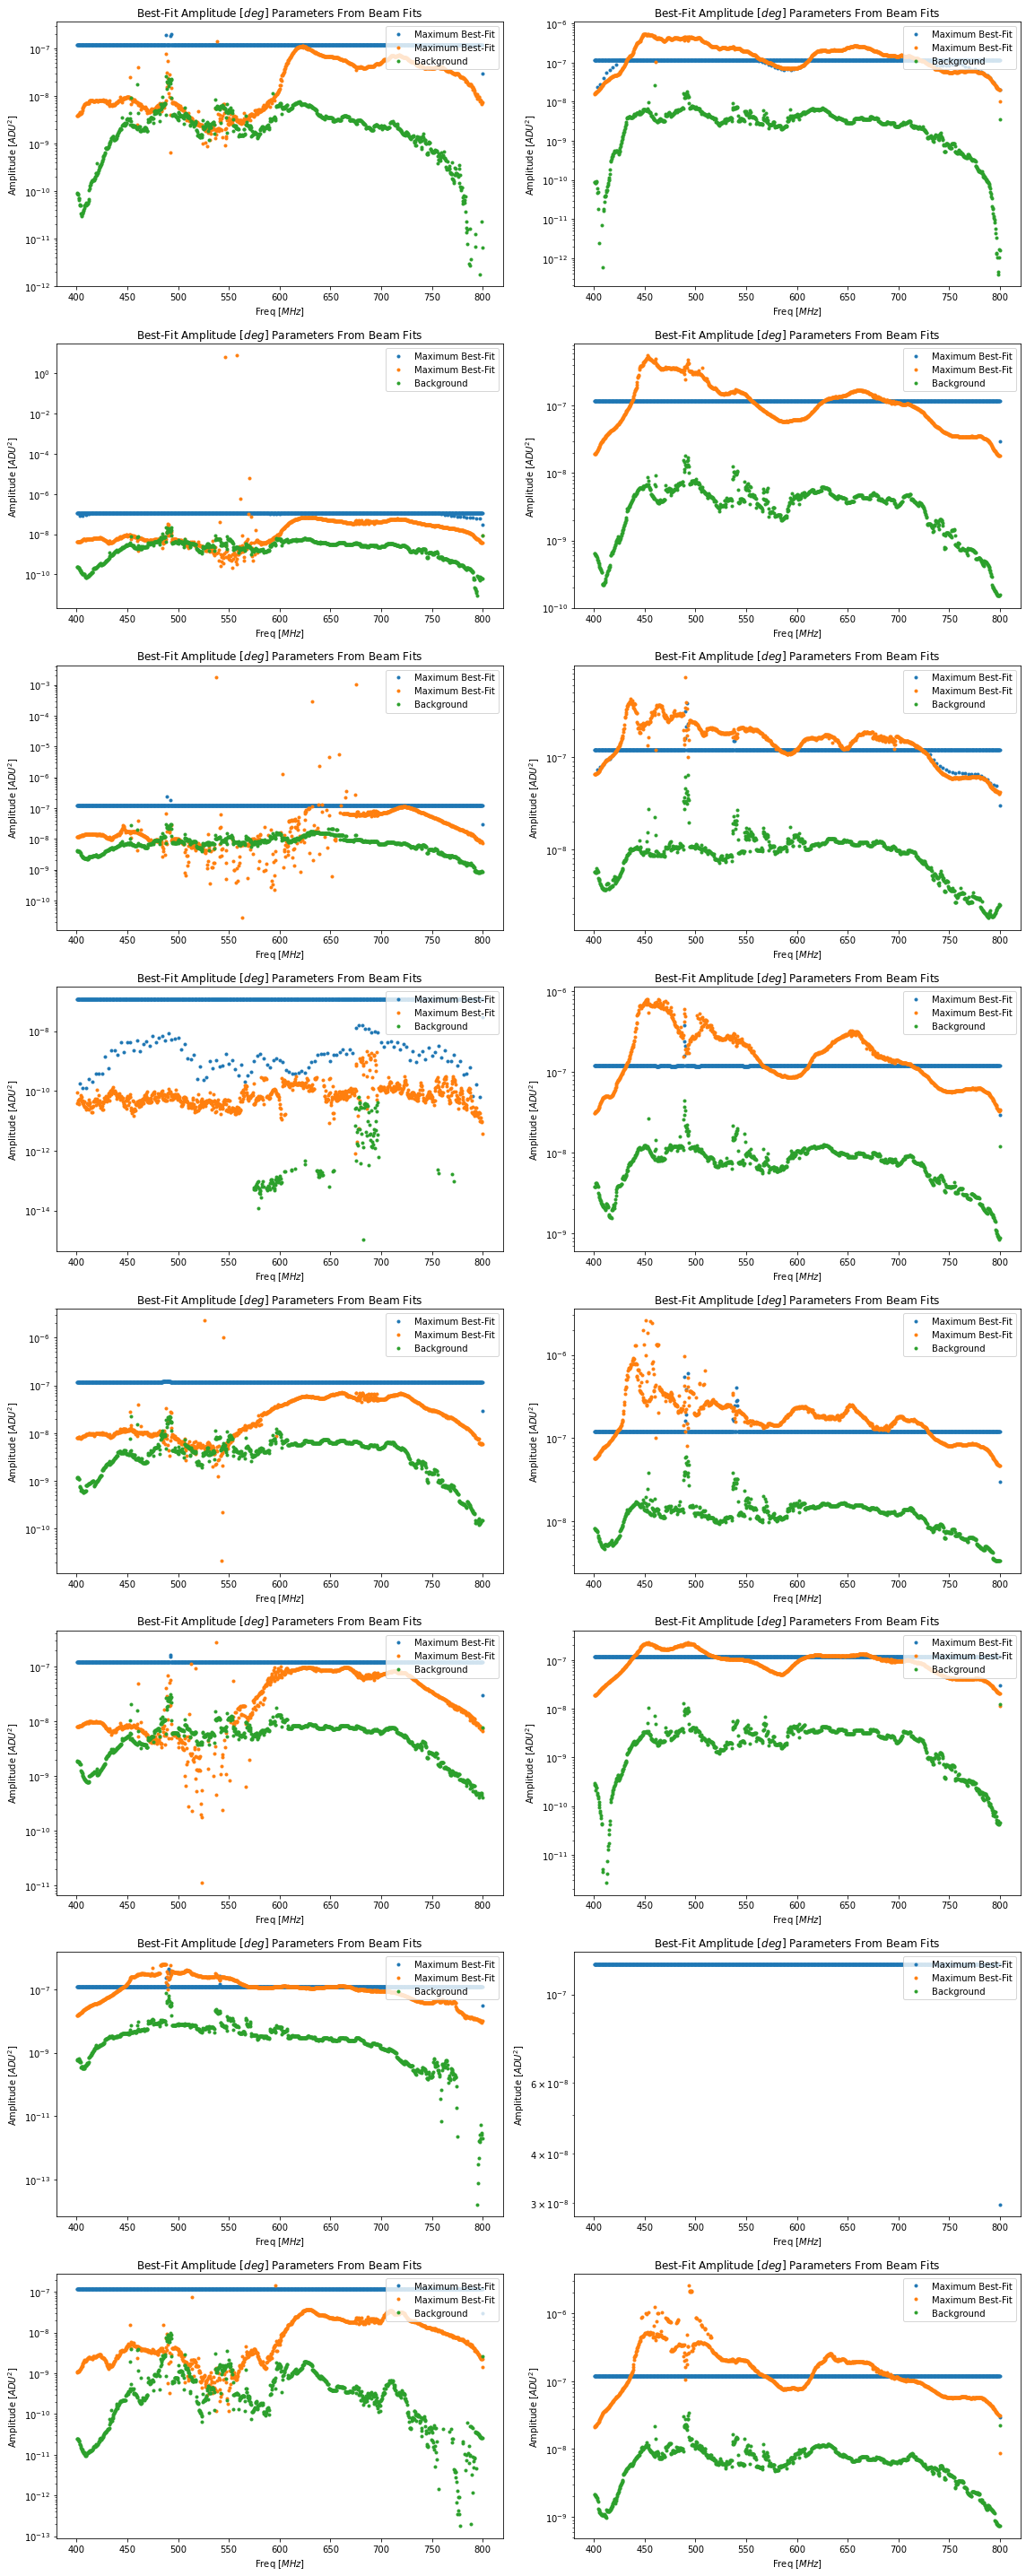

In [5]:
#plot(concattest0825.freq,G_popt[1,:,0],'.')
## FWHM in meters (x,y) and degrees in FoV:
#Afwhmm_f=2*1.616/3.832*AFit_f_params[:,:,3]
#Afwhmd_f=2*180.0/np.pi*np.arctan(1.616/3.832*AFit_f_params[:,:,3]/np.nanmean(mbz))


#pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])

    
Gfwhmxm_f=2.355*G_popt[:,:,2]
Gfwhmxd_f=2*180.0/np.pi*np.arctan(0.5*2.355*G_popt[:,:,2]/np.nanmean([175]))
Gfwhmym_f=2.355*G_popt[:,:,4]
Gfwhmyd_f=2*180.0/np.pi*np.arctan(0.5*2.355*G_popt[:,:,4]/np.nanmean([175]))

wavelength_m=(3.0*(10.0**8.0))/(concattest0825.freq*1.0e6)
difflimit=180.0/np.pi*1.22*wavelength_m

fwhms_bensims_f=np.linspace(400,800,9)
fwhms_bensims_E = [8.9, 7.9, 6.7, 6.1, 5.5, 5.1, 4.9, 6.6, 4.7]
fwhms_bensims_H = [7.7, 6.9, 6.3, 5.8, 5.3, 5, 5.2, 4, 4.2]
    
g=1   
    
fig1=figure(figsize=(16,40))
for g in range(16):
    ax=fig1.add_subplot(8,2,int(g+1))
    ax.plot(concattest0825.freq,Gfwhmxd_f[g],'.',label="BF2DGauss FWHM X")
    ax.plot(concattest0825.freq,Gfwhmyd_f[g],'.',label="BF2DGauss FWHM Y")
    ax.plot(concattest0825.freq,difflimit/6.0,'k-',markersize=0.5,label="Diffraction Limit D=6$m$")
    ax.plot(concattest0825.freq,difflimit/4.5,'k--',markersize=0.5,label="Diffraction Limit D=4.5$m$")
    ax.plot(fwhms_bensims_f,fwhms_bensims_E,'kv--',label="Simulated FWHM E")
    ax.plot(fwhms_bensims_f,fwhms_bensims_H,'kx--',label="Simulated FWHM H")
    ax.legend(loc=1)
    ax.set_ylabel("FWHM [$deg$]")
    ax.set_xlabel("Freq [$MHz$]")
    ax.set_title("Best-Fit FWHM [$deg$] Parameters From Beam Fits")
    ax.set_ylim(0,12)
tight_layout()

fig2=figure(figsize=(16,40))
for g in range(16):
    ax=fig2.add_subplot(8,2,int(g+1))
    ax.semilogy(concattest0825.freq,np.nanmax(concattest0825.V[:,:,g],axis=0),'.',label="Maximum Best-Fit")
    ax.semilogy(concattest0825.freq,G_popt[g,:,0],'.',label="Maximum Best-Fit")
    ax.semilogy(concattest0825.freq,G_popt[g,:,6],'.',label="Background")
    ax.legend(loc=1)
    ax.set_ylabel("Amplitude [$ADU^2$]")
    ax.set_xlabel("Freq [$MHz$]")
    ax.set_title("Best-Fit Amplitude [$deg$] Parameters From Beam Fits")
tight_layout()

In [417]:
## 2) 0826 -- Flight from 20210826T185621: Comments only include "Large Grid 3"

## Read in the Corr_Data class:
datadir='/hirax/GBO_Aug_2021/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/'
gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T185621Z_yale_drone_yale_digitalgain/'
corrtest0826=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite)

## Read in the Drone_Data class:
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0826=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY534.csv',site_class=gbosite)

## Since we know the data are from the same time we can combine them with the Concat_Class:
plot(dronetest0826.t_arr_datetime)
plot(corrtest0826.t_arr_datetime)
concattest0826=concat.CONCAT(CORRDATCLASS=corrtest0826,DRONEDATCLASS=dronetest0826)

## Use the Extract_Source_Pulses and Perform_Background_Subtraction functions:
concattest0826.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[14500,15000])
concattest0826.Perform_Background_Subtraction()
concattest0826.Synchronization_Function(inputcorr=corrtest0826,inputdrone=dronetest0826)
pu.Synchronization_Verification_Plots(concattest0826,chans=np.arange(0,2),find=900)

Initializing Correlator Class using:
 --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/
 --> Arrays initialized with shape (97, 256, 1024, 8)
Assigning array values by reading in data files:
 --> Loading File: 0001/0096

KeyboardInterrupt: 

Initializing Correlator Class using:
 --> /hirax/GBO_Oct_2021/TONE_ACQ/20211021T144905Z_yale_drone/corr/20211021T144917Z/
 --> Arrays initialized with shape (97, 256, 1024, 16)
Assigning array values by reading in data files:
 --> Loading File: 0096/0096Initializing drone data via datcon_csv routine: FLY613.csv
 --> Skipping rows 1 to 499 to eliminate NAN values
 --> Attempting to load position data from RTK
 ----> RTK data contains 0/15570 non-nan values
 ----> RTK Data not usable for this data file...
 --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
 --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
 --> generating dish and receiver line of sight coordinates.
Initializing CONCAT CLASS using:
 --> /hirax/GBO_Oct_2021/TONE_ACQ/20211021T144905Z_yale_drone/corr/20211021T144917Z/
 --> FLY613.csv
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 24832 elements
  

/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:124: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.nanmax(minsubdata)
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:138: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:124: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.nanmax(minsubdata)
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:138: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:124: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.nanmax(minsubdata)
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:138: RuntimeWarnin

Maximum Pearson_R Correlations:
  --> t_indices = [ 95.  89.  89.  89.  nan  nan  99.  89.  89.  89. 112.  87.  89.  nan
 106.  91.]
  --> t_offsets = [-0.36196196 -0.36436436 -0.36436436 -0.36436436         nan         nan
 -0.36036036 -0.36436436 -0.36436436 -0.36436436 -0.35515516 -0.36516517
 -0.36436436         nan -0.35755756 -0.36356356]
Selecting global time offset:
  --> global_t_offset = -0.3433928444
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:192: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  tight_layout()
/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Applying a time correction of -1.37 seconds using Channel 1 fits.


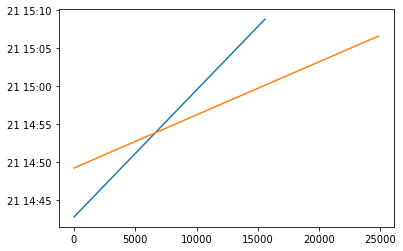

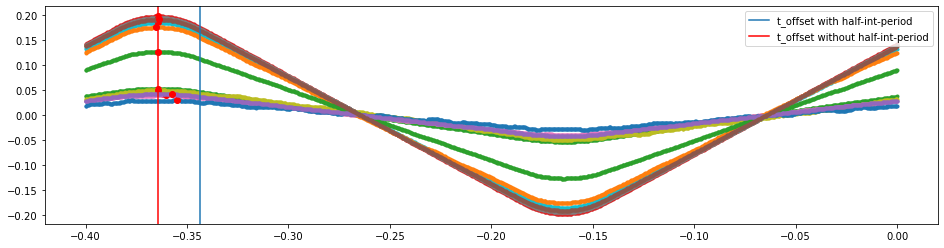

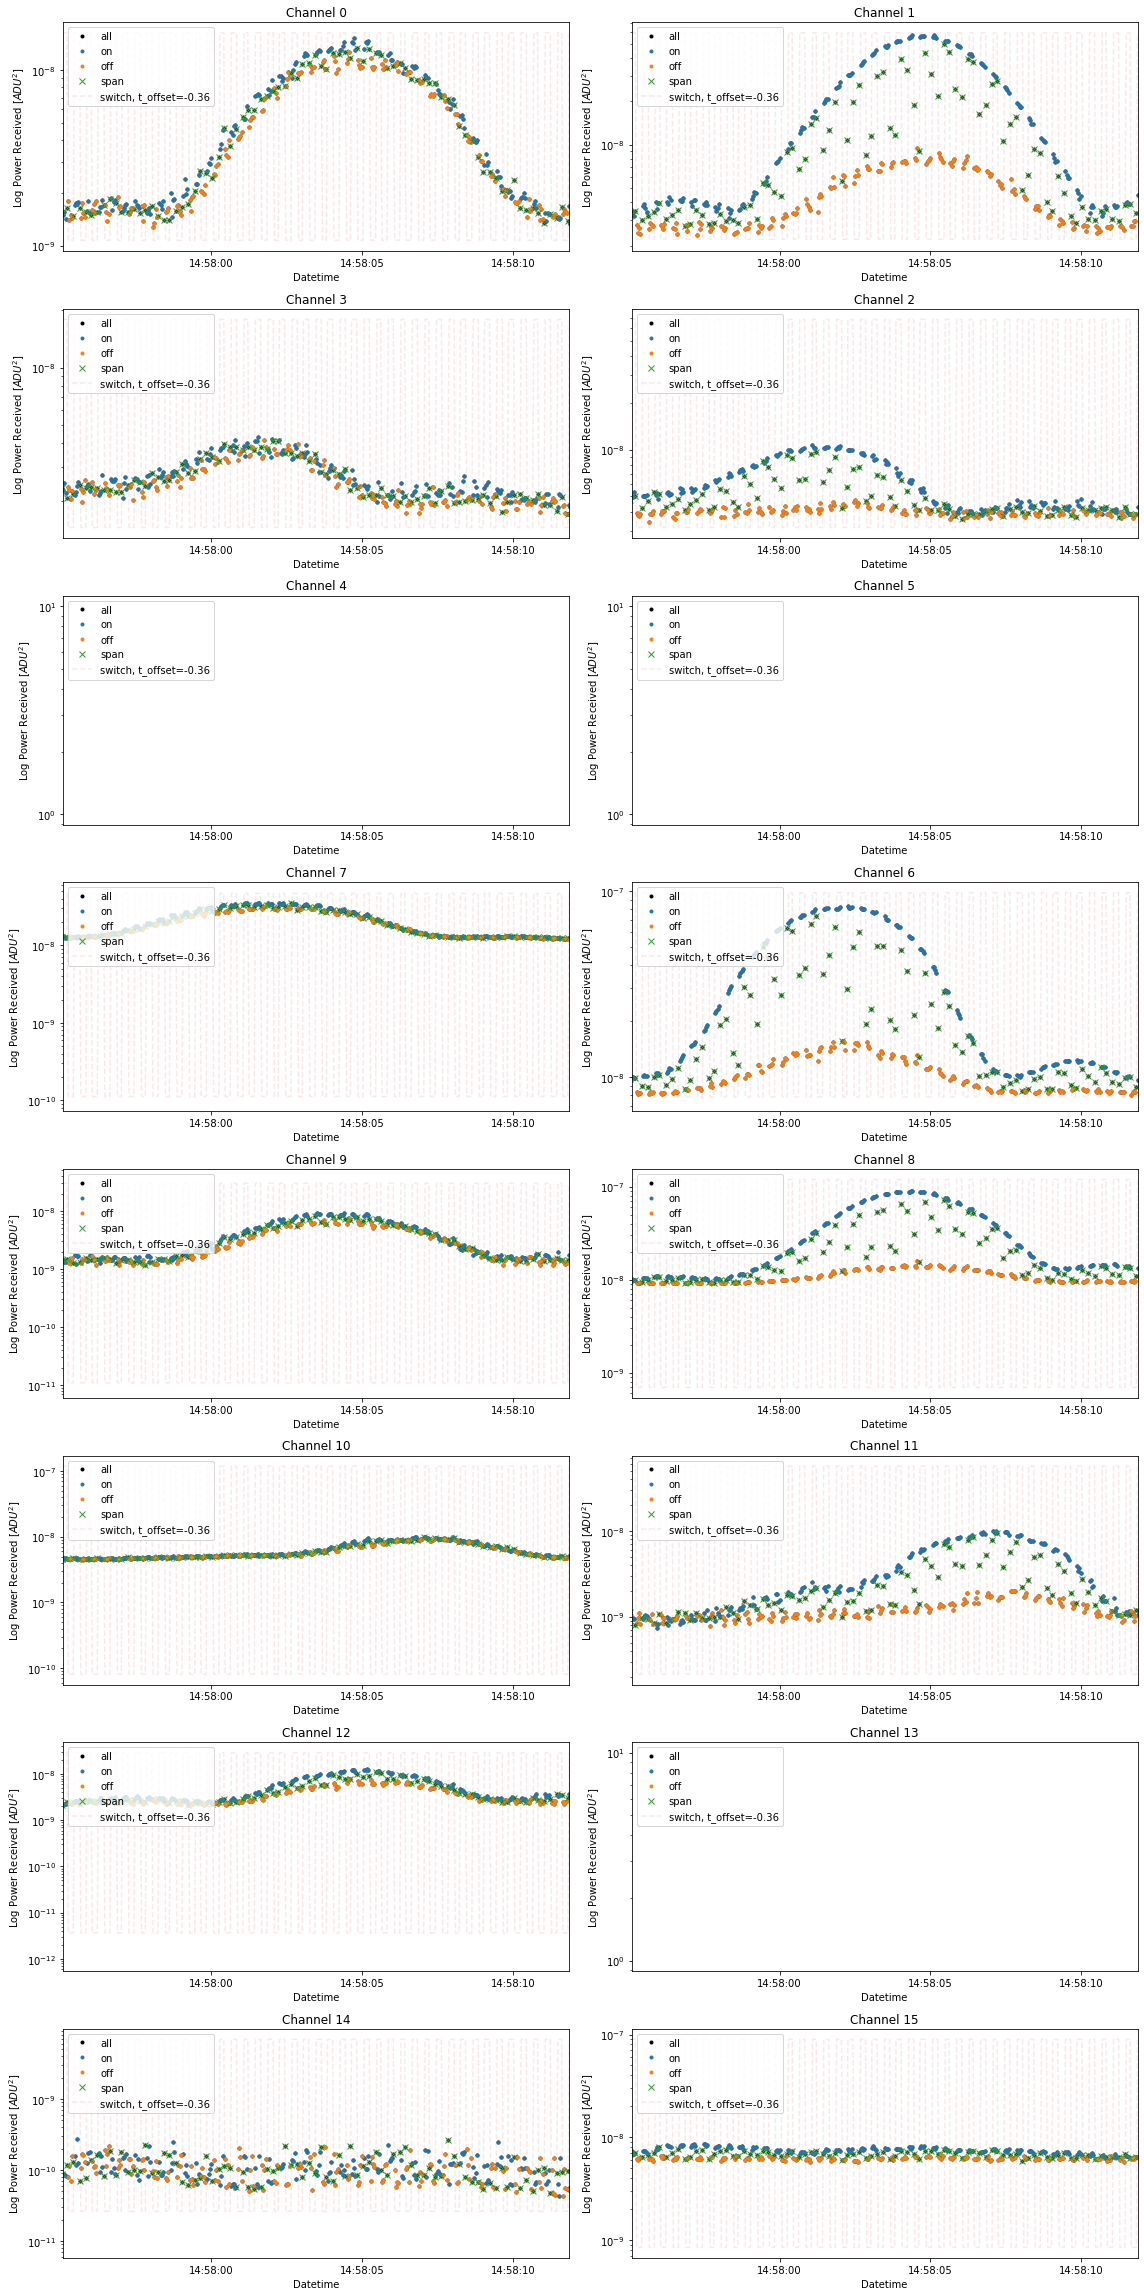

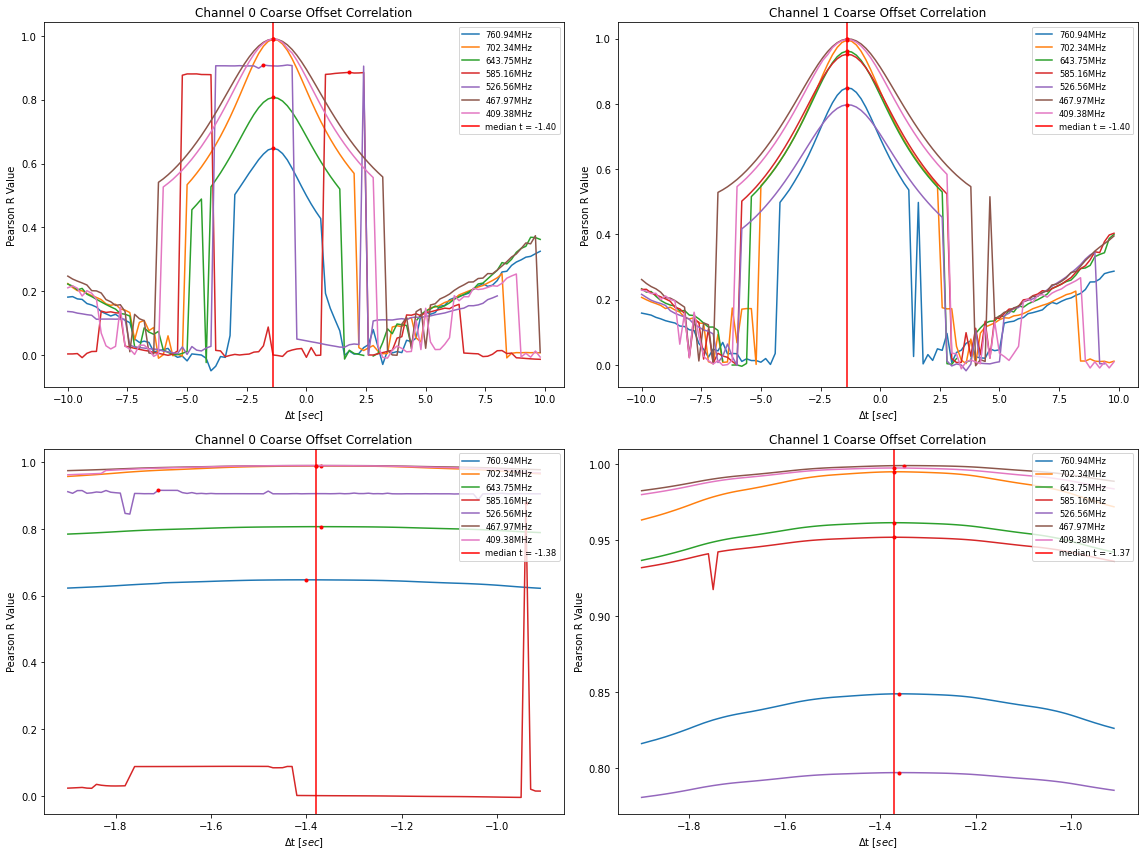

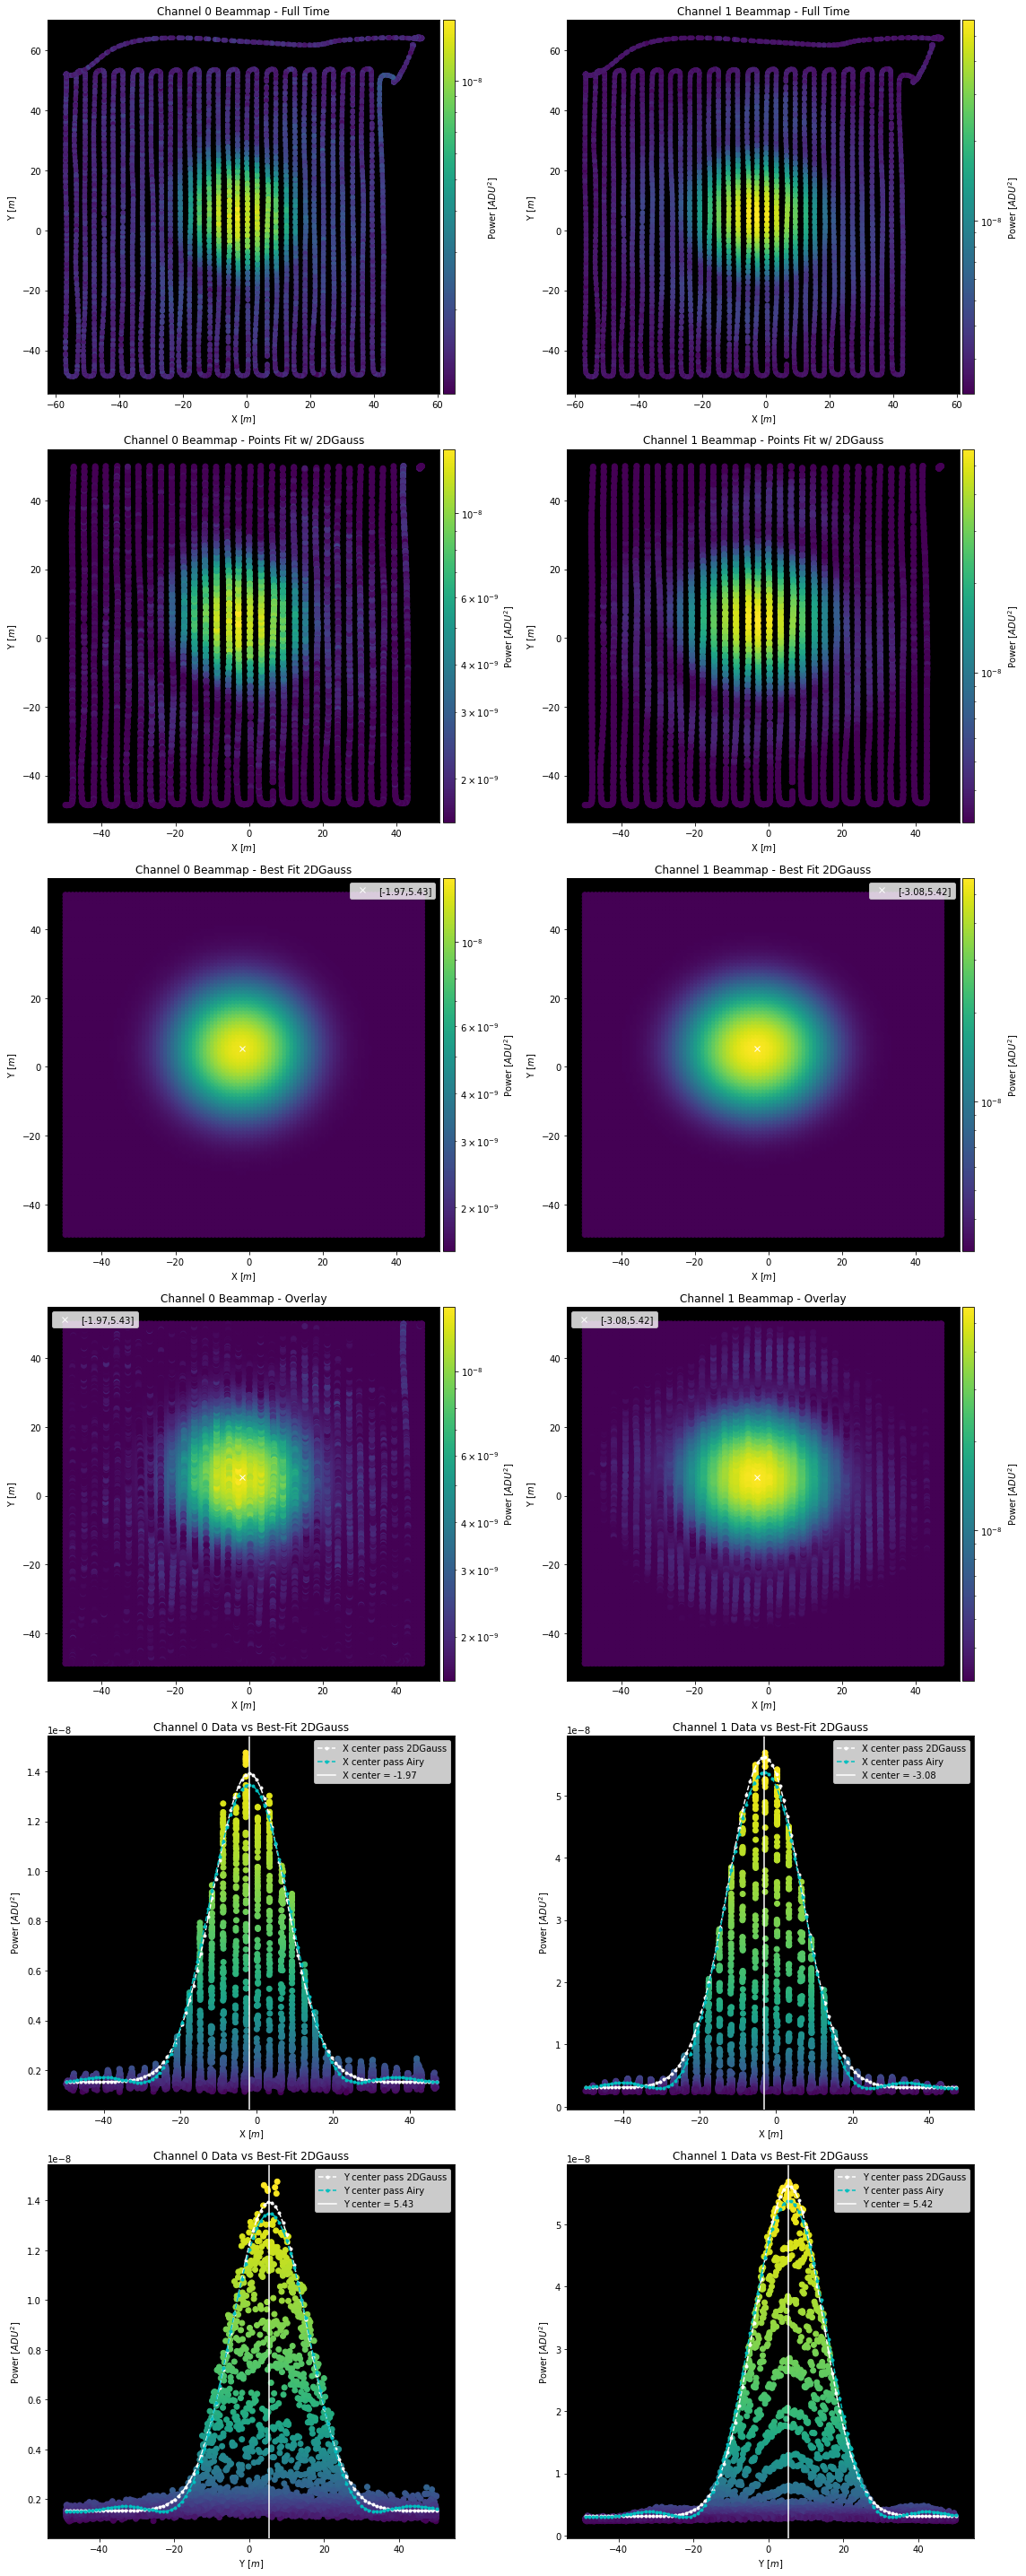

In [6]:
## 3) 1021 -- Flight from 20210826T185621: Comments only include "Large Grid 3"

## Read in the Corr_Data class:
datadir='/hirax/GBO_Oct_2021/TONE_ACQ/20211021T144905Z_yale_drone/corr/20211021T144917Z/'
gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211021T144905Z_yale_drone_yale_digitalgain/'
corrtest1021=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite)

## Read in the Drone_Data class:
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest1021=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY613.csv',site_class=gbosite)

## Since we know the data are from the same time we can combine them with the Concat_Class:
plot(dronetest1021.t_arr_datetime)
plot(corrtest1021.t_arr_datetime)
concattest1021=concat.CONCAT(CORRDATCLASS=corrtest1021,DRONEDATCLASS=dronetest1021)

## Use the Extract_Source_Pulses and Perform_Background_Subtraction functions:
concattest1021.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[12400,12800])
concattest1021.Perform_Background_Subtraction()
concattest1021.Synchronization_Function(inputcorr=corrtest1021,inputdrone=dronetest1021)
pu.Synchronization_Verification_Plots(concattest1021,chans=np.arange(0,2),find=900)

Initializing Correlator Class using:
 --> /hirax/GBO_Oct_2021/TONE_ACQ/20211022T194308Z_yale_drone/corr/20211022T194320Z/
 --> Arrays initialized with shape (113, 256, 1024, 16)
Assigning array values by reading in data files:
 --> Loading File: 0112/0112Initializing drone data via datcon_csv routine: FLY649.csv
 --> Skipping rows 1 to 499 to eliminate NAN values
 --> Attempting to load position data from RTK
 ----> RTK Data not found for this data file...
 --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
 --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
 --> generating dish and receiver line of sight coordinates.
Initializing CONCAT CLASS using:
 --> /hirax/GBO_Oct_2021/TONE_ACQ/20211022T194308Z_yale_drone/corr/20211022T194320Z/
 --> FLY649.csv
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 26832 elements
  --> drone timestamp axis contains 11489 elements

/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:124: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.nanmax(minsubdata)
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:138: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]


Maximum Pearson_R Correlations:
  --> t_indices = [554. 551. 566. 566. 552. 565. 555. 554. 561. 560. 560. 561. 561.  nan
 572. 573.]
  --> t_offsets = [-0.17817818 -0.17937938 -0.17337337 -0.17337337 -0.17897898 -0.17377377
 -0.17777778 -0.17817818 -0.17537538 -0.17577578 -0.17577578 -0.17537538
 -0.17537538         nan -0.17097097 -0.17057057]
Selecting global time offset:
  --> global_t_offset = -0.1544038554
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:192: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  tight_layout()
/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


Applying a time correction of -3.45 seconds using Channel 0 fits.


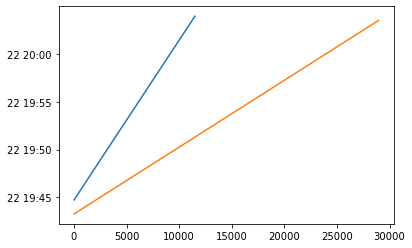

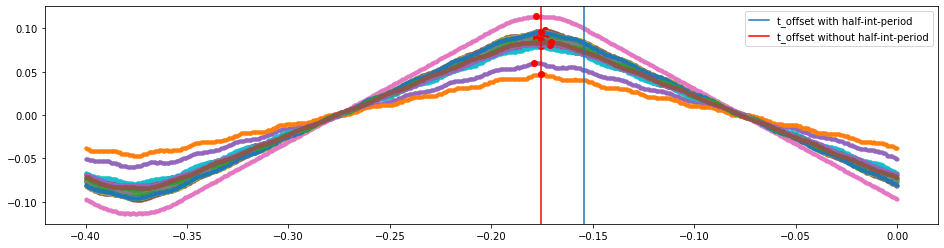

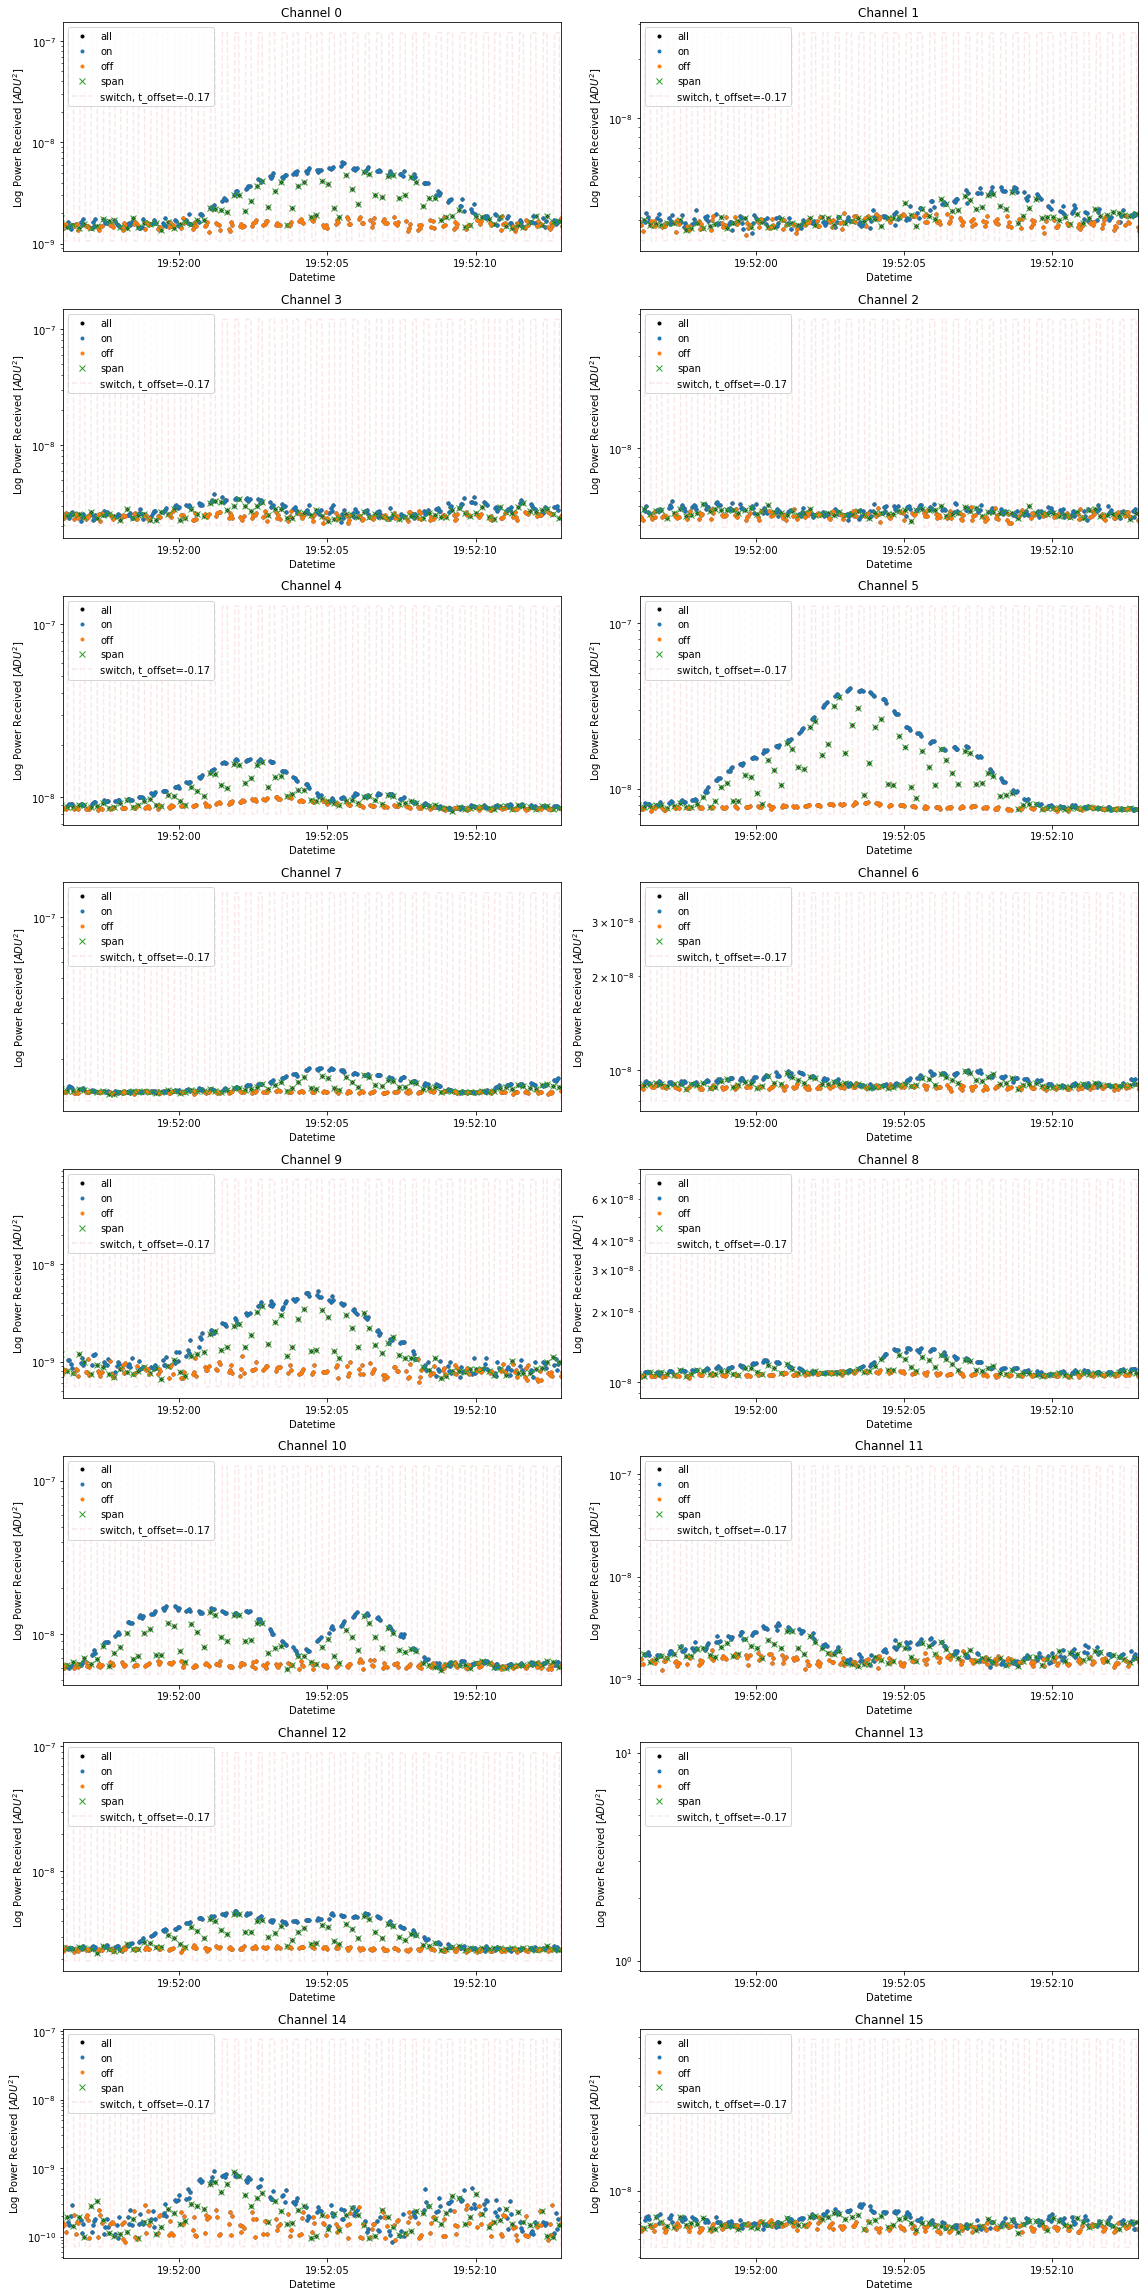

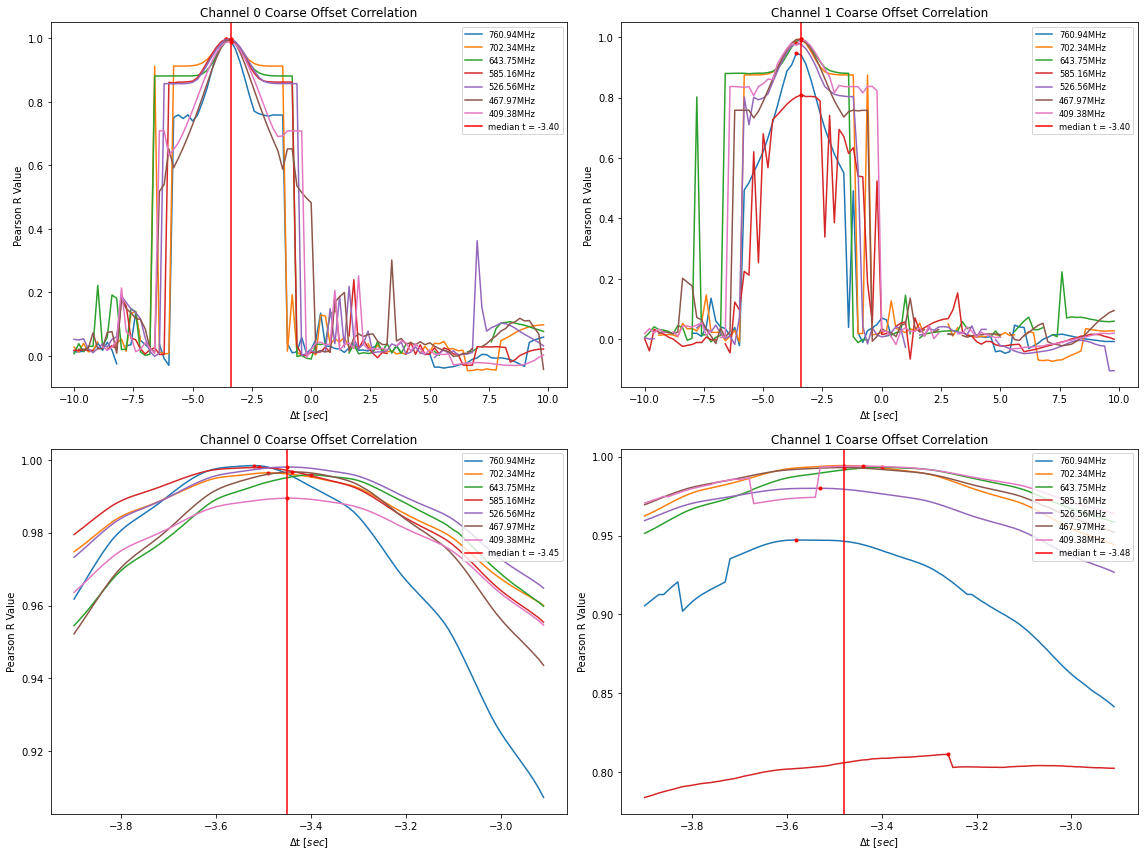

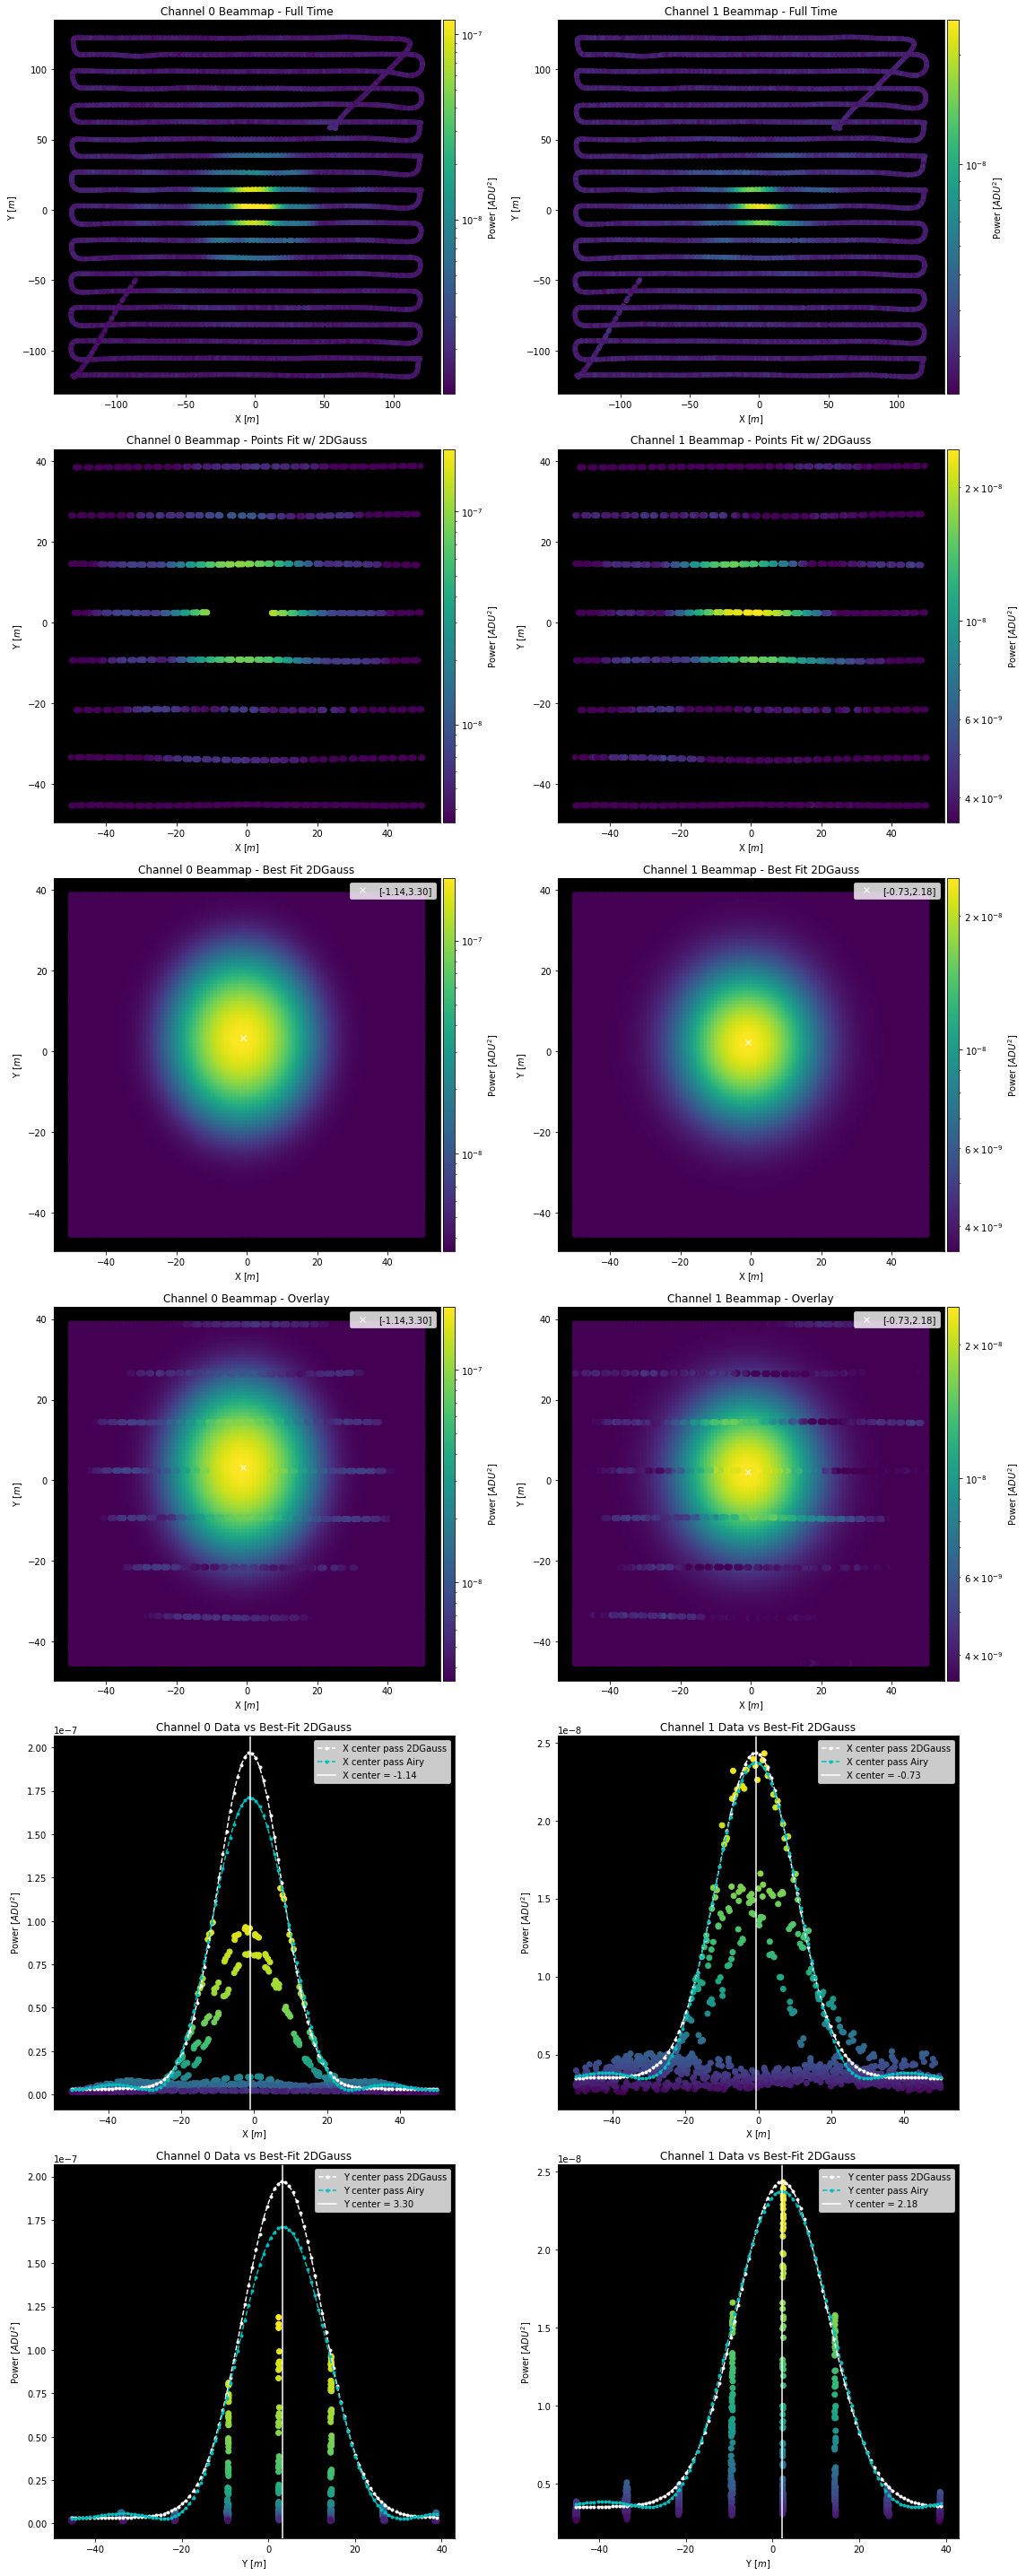

In [7]:
## Trying to examine time offsets from different flights to look for patterns/systematic issues:
## 4) 1022 -- Flight from 20211022T194308: Comments only include "Big Grid 4"

## Read in the Corr_Data class:
datadir='/hirax/GBO_Oct_2021/TONE_ACQ/20211022T194308Z_yale_drone/corr/20211022T194320Z/'
gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211022T194308Z_yale_drone_yale_digitalgain/'
corrtest1022=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite)

## Read in the Drone_Data class:
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest1022=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY649.csv',site_class=gbosite)

## Since we know the data are from the same time we can combine them with the Concat_Class:
plot(dronetest1022.t_arr_datetime)
plot(corrtest1022.t_arr_datetime)
concattest1022=concat.CONCAT(CORRDATCLASS=corrtest1022,DRONEDATCLASS=dronetest1022)

## Use the Extract_Source_Pulses and Perform_Background_Subtraction functions:
concattest1022.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[12400,12800])
concattest1022.Perform_Background_Subtraction()
concattest1022.Synchronization_Function(inputcorr=corrtest1022,inputdrone=dronetest1022)
pu.Synchronization_Verification_Plots(concattest1022,chans=np.arange(0,2),find=900)